In [1]:
import numpy as np
import torch
import ot
from ot.datasets import make_1D_gauss as gauss
from sparse_ot.full_repr import get_gamma
from sparse_ot.full_repr_autok import get_gamma as get_gamma_k
from sparse_ot.uot_mmd import solve_apgd
from sparse_ot.utils import get_G, get_dist, offd_dist, postprocess_gamma
import ot.plot
import matplotlib.pyplot as plt

# For input size m = n = 10 and k = m x n

In [2]:
m, n = 10, 10
device = torch.device("cuda")
x = torch.arange(m).float().to(device)
y = torch.arange(n).float().to(device)
lda = 100

a = torch.from_numpy(gauss(m, 5, 1)).float().to(device)
b = torch.from_numpy(gauss(n, 5, 1)).float().to(device)
v = {1: a, 2: b}

K = 20  # m*n
max_itr = 500

def get_cost_G(x, y, khp, ktype, p=2):
    # None means taking median-heuristic
    C = get_dist(x, y, p)
    C = C/C.max()
    
    G1 = get_G(x=x, y=x, khp=khp, ktype=ktype)
    G2 = get_G(x=y, y=y, khp=khp, ktype=ktype)
    G = {1: G1, 2: G2}
    return C, G

In [3]:
print(offd_dist(get_dist(x, x, 1), 5))
print(offd_dist(get_dist(y, y, 1), 5))

{'min_dist': tensor(1., device='cuda:0'), 'max_dist': tensor(9., device='cuda:0'), 'med_dist': tensor(3., device='cuda:0'), 'minn_dist': {1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}}
{'min_dist': tensor(1., device='cuda:0'), 'max_dist': tensor(9., device='cuda:0'), 'med_dist': tensor(3., device='cuda:0'), 'minn_dist': {1: 2.0, 2: 3.0, 3: 4.0, 4: 5.0}}


In [4]:
C, G = get_cost_G(x=x, y=y, khp=1, ktype="rbf")
torch.linalg.cond(G[1]), torch.linalg.cond(G[2])

(tensor(46.7281, device='cuda:0'), tensor(46.7281, device='cuda:0'))

## OT-MMD

In [5]:
orig_gamma, obj_itr = solve_apgd(C, G[1], G[2], v[1], v[2], max_itr, lda, prog=1)
print("Final_obj {}".format(obj_itr[-1]))

Final_obj 0.006564612500369549


## Sparse-OT-Dash

In [6]:
%%time
gamma = get_gamma(C, G[1], G[2], v[1], v[2], max_itr, lda, K, all_gamma=0)

CPU times: user 788 ms, sys: 1.5 ms, total: 790 ms
Wall time: 789 ms


In [7]:
%%time
gamma_k = get_gamma_k(C, G[1], G[2], v[1], v[2], max_itr, lda, all_gamma=0)

CPU times: user 394 ms, sys: 0 ns, total: 394 ms
Wall time: 394 ms


## Stochastic-Sparse-OT-Dash

In [8]:
%%time
gamma_stoch = get_gamma(C, G[1], G[2], v[1], v[2], max_itr, lda, K, s=50, all_gamma=0)

CPU times: user 784 ms, sys: 0 ns, total: 784 ms
Wall time: 784 ms


In [9]:
%%time
gamma_stoch_k = get_gamma_k(C, G[1], G[2], v[1], v[2], max_itr, lda, s=50, all_gamma=0)

CPU times: user 986 ms, sys: 0 ns, total: 986 ms
Wall time: 985 ms


#### Comparing gamma's

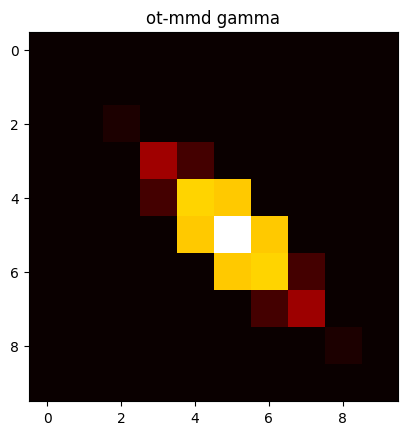

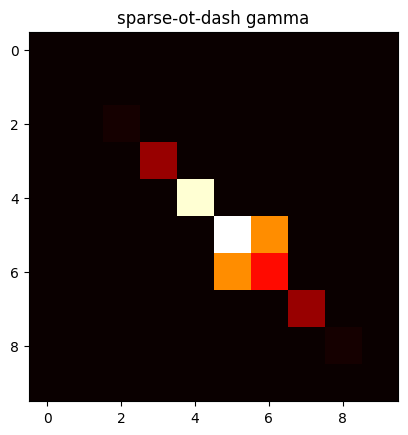

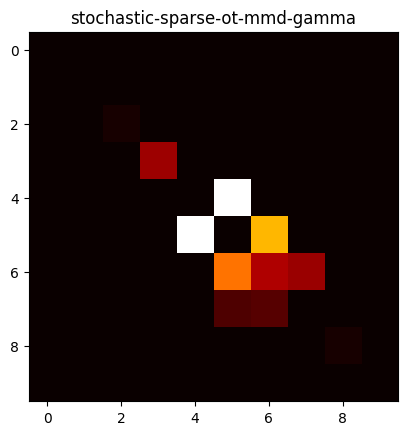

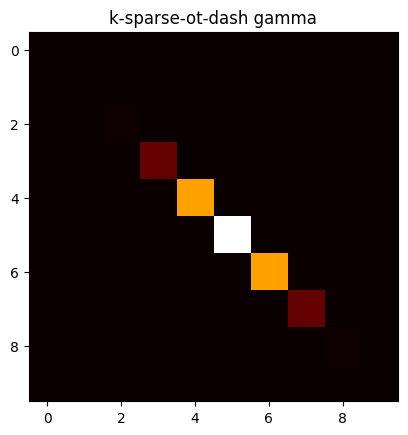

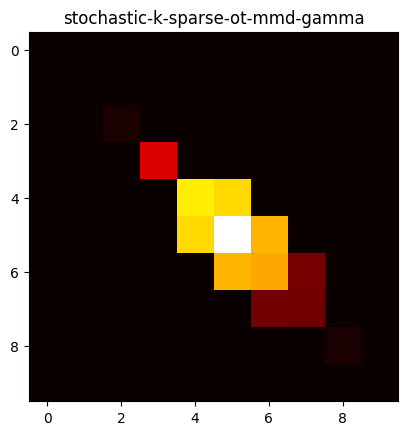

In [10]:
def plot_gamma(a, b, gamma, title):
    plt.clf()
    plt.title(title)
    plt.imshow(gamma.cpu().numpy(), cmap="hot")
    plt.show()

plot_gamma(v[1], v[2], orig_gamma, "ot-mmd gamma")
plot_gamma(v[1], v[2], gamma, "sparse-ot-dash gamma")
plot_gamma(v[1], v[2], gamma_stoch, "stochastic-sparse-ot-mmd-gamma")
plot_gamma(v[1], v[2], gamma_k, "k-sparse-ot-dash gamma")
plot_gamma(v[1], v[2], gamma_stoch_k, "stochastic-k-sparse-ot-mmd-gamma")

#### Effect of s

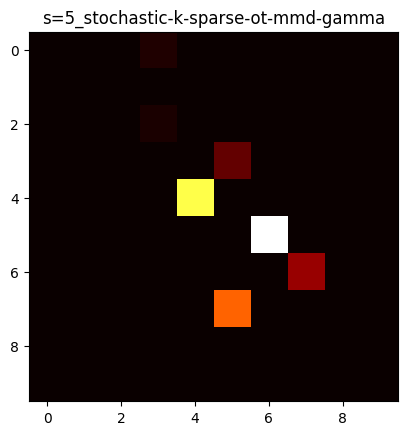

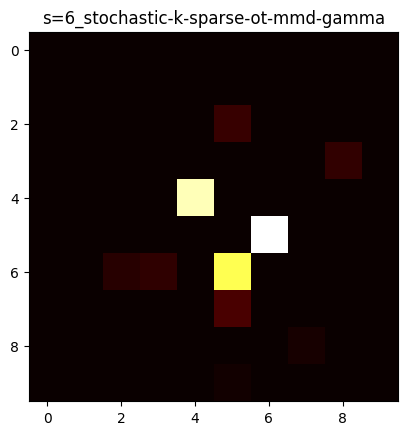

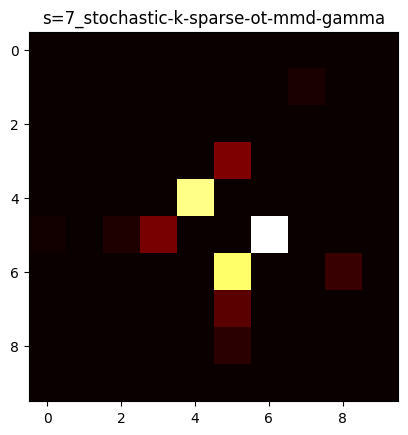

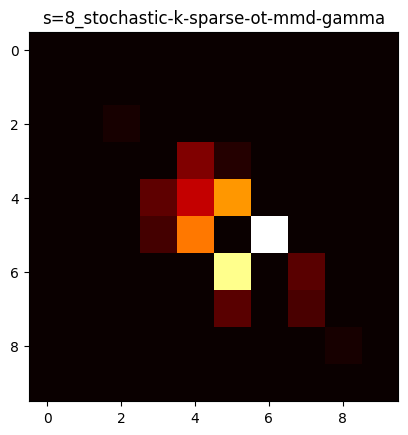

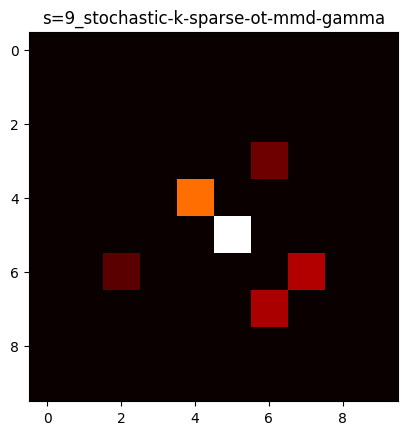

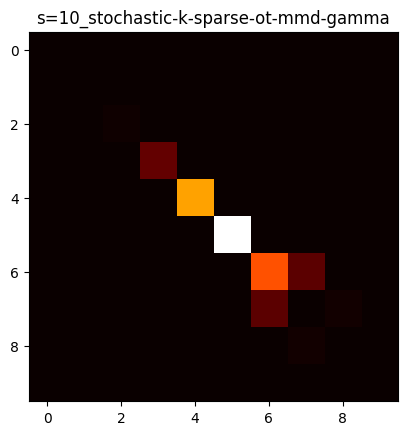

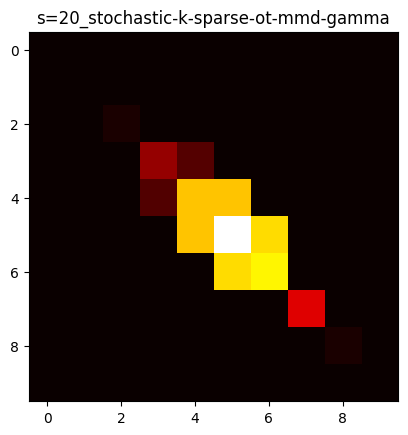

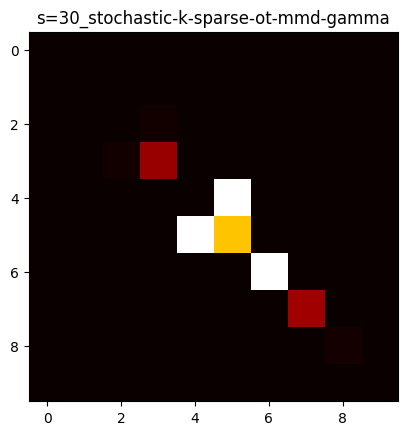

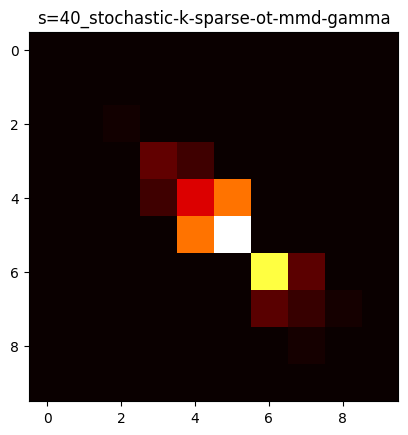

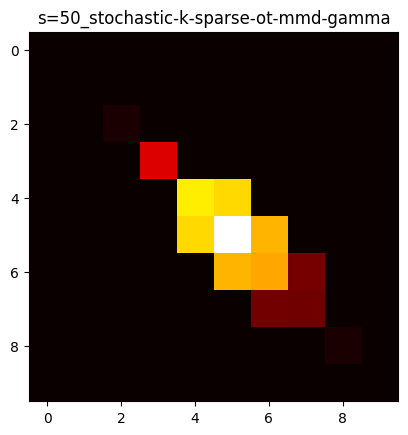

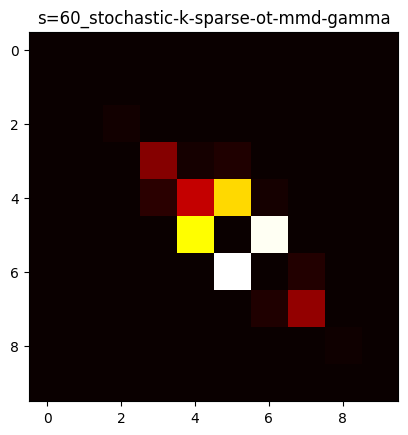

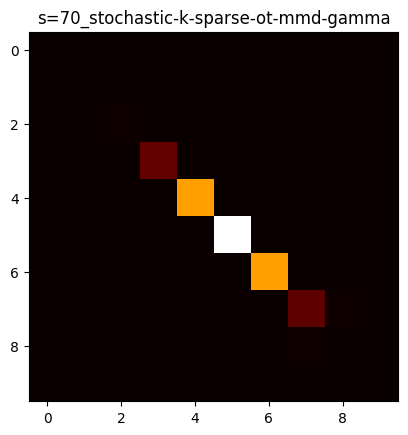

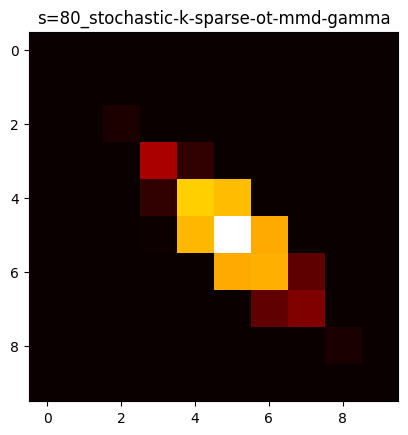

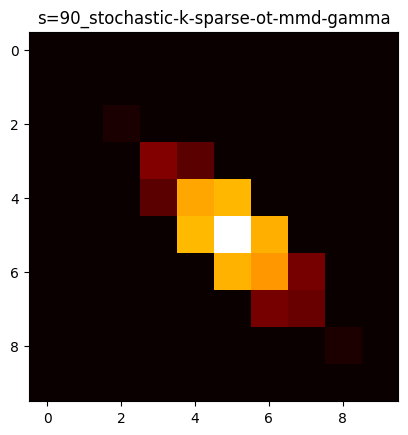

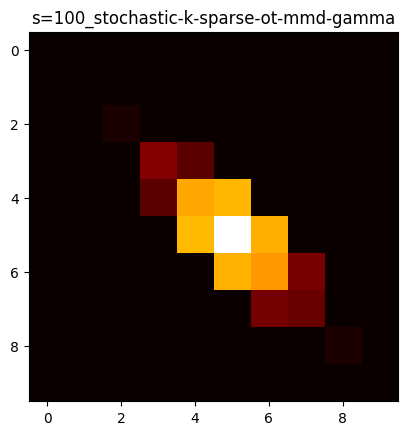

In [11]:
for s in [5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    gamma_stoch_k = get_gamma_k(C, G[1], G[2], v[1], v[2], max_itr, lda, s=s, all_gamma=0)
    plot_gamma(v[1], v[2], gamma_stoch_k, "s={}_stochastic-k-sparse-ot-mmd-gamma".format(s))

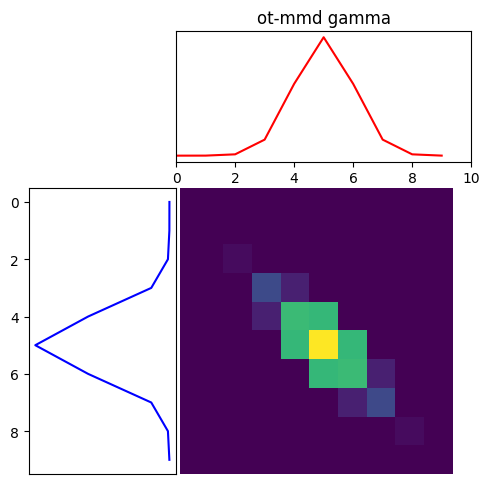

In [12]:
plt.figure(2, figsize=(5, 5))
ot.plot.plot1D_mat(v[1].cpu().numpy(), v[2].cpu().numpy(), orig_gamma.cpu().numpy(), "ot-mmd gamma")

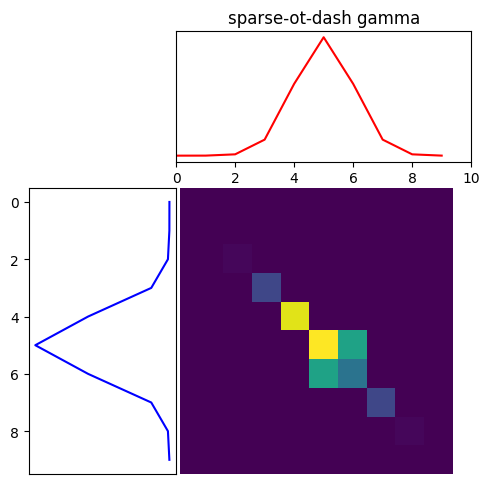

In [13]:
plt.figure(2, figsize=(5, 5))
ot.plot.plot1D_mat(v[1].cpu().numpy(), v[2].cpu().numpy(), gamma.cpu().numpy(), "sparse-ot-dash gamma")

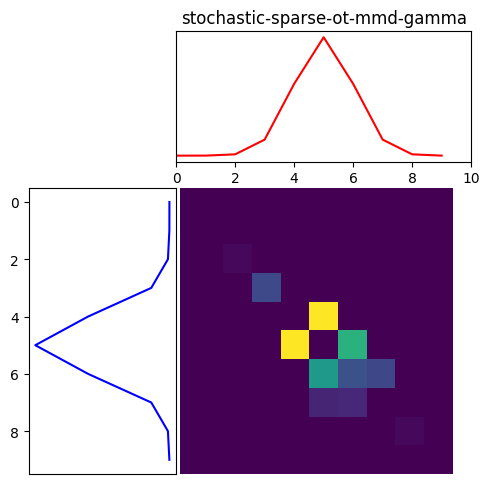

In [14]:
plt.figure(2, figsize=(5, 5))
ot.plot.plot1D_mat(v[1].cpu().numpy(), v[2].cpu().numpy(), gamma_stoch.cpu().numpy(), "stochastic-sparse-ot-mmd-gamma")